/home/kjetil/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


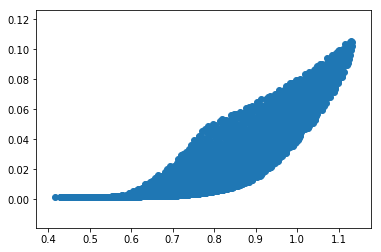

Training examples summary:


,x,y,z
count,16.0,16.0,16.0
mean,0.5,0.5,0.5
std,0.3,0.3,0.3
min,0.1,0.1,0.1
25%,0.2,0.3,0.3
50%,0.6,0.5,0.5
75%,0.7,0.8,0.8
max,0.9,1.0,0.9


Validation examples summary:


,x,y,z
count,400.0,400.0,400.0
mean,0.5,0.5,0.5
std,0.3,0.3,0.3
min,0.0,0.0,0.0
25%,0.2,0.3,0.2
50%,0.5,0.5,0.5
75%,0.7,0.7,0.7
max,1.0,1.0,1.0


Training targets summary:


,lift
count,16.0
mean,0.8
std,0.2
min,0.5
25%,0.6
50%,0.8
75%,0.9
max,1.1


Validation targets summary:


,lift
count,400.0
mean,0.8
std,0.2
min,0.4
25%,0.6
50%,0.8
75%,0.9
max,1.1


Training model...
RMSE (on training data):
(16,)
(16, 1)
  period 00 : 0.00
(16,)
(16, 1)
  period 01 : 0.00
(16,)
(16, 1)
  period 02 : 0.00
(16,)
(16, 1)
  period 03 : 0.00
(16,)
(16, 1)
  period 04 : 0.00
(16,)
(16, 1)
  period 05 : 0.00
(16,)
(16, 1)
  period 06 : 0.00
(16,)
(16, 1)
  period 07 : 0.00
(16,)
(16, 1)
  period 08 : 0.00
(16,)
(16, 1)
  period 09 : 0.00
Model training finished.


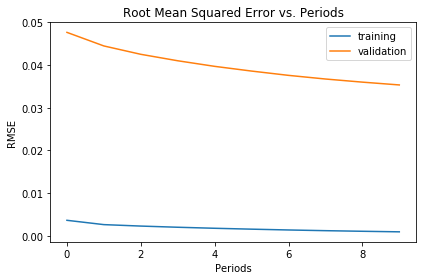

Final RMSE (on training data):   0.00
Final RMSE (on validation data): 0.04


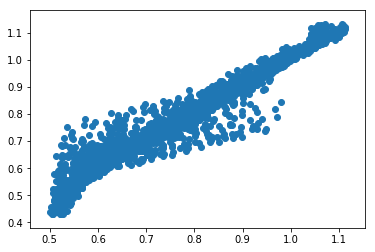

In [1]:
# -*- coding: utf-8 -*-
"""improving_neural_net_performance.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/notebooks/mlcc/improving_neural_net_performance.ipynb

#### Copyright 2017 Google LLC.
"""

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""# Improving Neural Net Performance

**Learning Objective:** Improve the performance of a neural network by normalizing features and applying various optimization algorithms

**NOTE:** The optimization methods described in this exercise are not specific to neural networks; they are effective means to improve most types of models.

## Setup

First, we'll load the data.
"""

import math

from IPython import display
import matplotlib
%matplotlib inline
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

qmc_points = np.loadtxt('../sobol_4_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,4))

forces = np.array(np.loadtxt('../force_L2_scaled.dat'))

datapoints = pd.DataFrame()
datapoints['lift'] = forces[:,1]
datapoints['drag'] = forces[:,2]
plt.scatter(forces[:,1], forces[:,2])
plt.show()

datapoints['x'] = qmc_points[:forces.shape[0],0]
datapoints['y'] = qmc_points[:forces.shape[0],1]
datapoints['z'] = qmc_points[:forces.shape[0],2]
datapoints['w'] = qmc_points[:forces.shape[0]   ,3]

force_name = 'lift'
train_number = 16
validation_number = 400

datapoints = datapoints.reindex(
    np.random.permutation(datapoints.index))

def preprocess_features(inputframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = inputframe[["x",
     "y",
     "z"]]
    
     #"w"]]
  processed_features = selected_features.copy()

  return processed_features

def preprocess_targets(input):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output = pd.DataFrame()
  output[force_name]=input[force_name]

  return output

# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(datapoints.head(train_number))
training_targets = preprocess_targets(datapoints.head(train_number))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(datapoints.tail(validation_number))
validation_targets = preprocess_targets(datapoints.tail(validation_number))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

"""## Train the Neural Network

Next, we'll train the neural network.
"""

def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.

    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """

    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in list(dict(features).items())}

    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)

    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.

  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.

  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.

  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )

  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples,
                                          training_targets[force_name],
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                  training_targets[force_name],
                                                  num_epochs=1,
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                    validation_targets[force_name],
                                                    num_epochs=1,
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])

    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

    # Compute training and validation loss.
    print(training_predictions.shape)
    print(training_targets.shape)
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  plt.show()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse
dnn, rmse, val_rmse = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=500000,
    batch_size=10,
    hidden_units=[10, 5, 5,10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


test_examples = preprocess_features(datapoints[train_number:forces.shape[1]-validation_number])
test_targets = preprocess_targets(datapoints[train_number:forces.shape[1]-validation_number])

predict_test_input_fn = lambda: my_input_fn(test_examples,
                                                    test_targets[force_name],
                                                    num_epochs=1,
                                                    shuffle=False)


test_predictions = dnn.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

plt.scatter(test_predictions, test_targets)
plt.show()

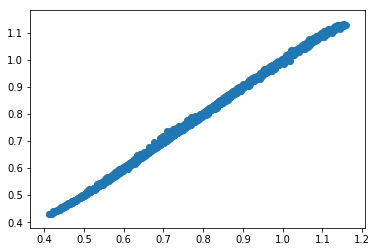

In [11]:
test_examples = preprocess_features(datapoints[train_number:forces.shape[1]-validation_number])
test_targets = preprocess_targets(datapoints[train_number:forces.shape[1]-validation_number])

predict_test_input_fn = lambda: my_input_fn(test_examples,
                                                    test_targets[force_name],
                                                    num_epochs=1,
                                                    shuffle=False)


test_predictions = dnn.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

plt.scatter(test_predictions, test_targets)
plt.show()

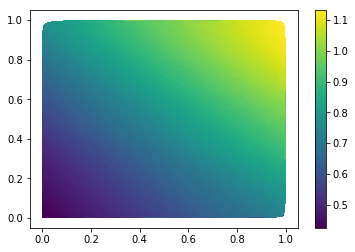

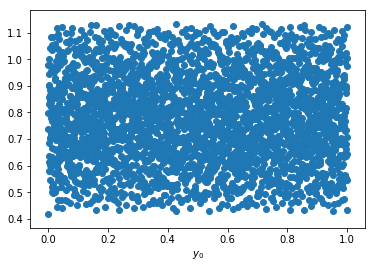

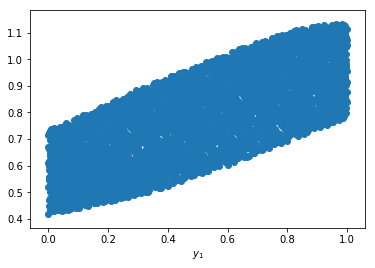

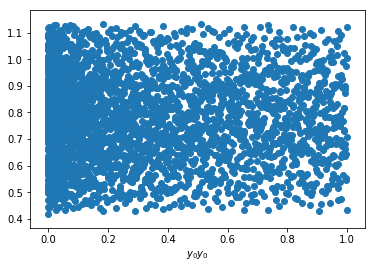

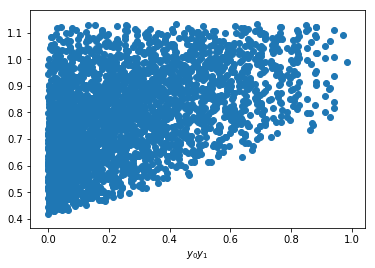

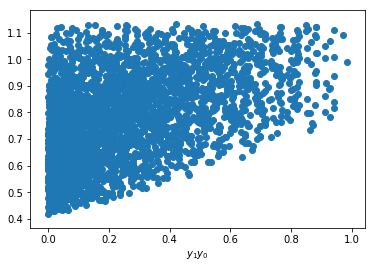

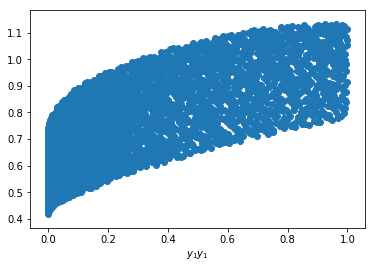

In [30]:
x = qmc_points[:forces.shape[0],2]
y = qmc_points[:forces.shape[0],1]
plt.tripcolor(x, y, forces[:,1])
plt.colorbar()
plt.show()

for i in range(0,2):
    x = qmc_points[:forces.shape[0],i]
    plt.scatter(x, forces[:,1])
    plt.xlabel('$y_{%d}$' % (i))
    
    plt.show()
        
for i in range(0,2):
    for j in range(0,2):
       
        x = qmc_points[:forces.shape[0],i]
        y = qmc_points[:forces.shape[0],j]
        plt.scatter(x*y, forces[:,1])
        plt.xlabel('$y_{%d}y_{%d}$' % (i,j))
        
        plt.show()
        